In [1]:
import pandas as pd
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import graphviz
import itertools
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
# import Kmeans from sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error
from typing import List, Union, Any, Tuple, Dict
import time
from permetrics.regression import RegressionMetric
import oapackage
from sklearn.cluster import DBSCAN
from scipy.stats import wasserstein_distance, binned_statistic
from decimal import Decimal, ROUND_HALF_UP
import warnings
warnings.filterwarnings('ignore')

# Project path
ppath = sys.path[0] + '/../'
sys.path.append(os.path.join(ppath, 'code'))
from discretizers import *
from end_to_end_pipeline import *
from SearchSpace import *

/Users/eylai/anaconda3/envs/lucid/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/eylai/anaconda3/envs/lucid/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


(CVXPY) Oct 21 05:21:17 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 21 05:21:17 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
dataset = 'satimage'
use_case = 'imputation'
# read json file
exp_config = json.load(open(os.path.join(ppath, 'code', 'configs', f'{dataset}.json')))
attributes = exp_config['attributes'].keys()

for attr in attributes:
    f_quality = []
    f_runtime = []
    # load experiment data
    data = pd.read_csv(os.path.join(ppath, 'experiment_data', dataset, use_case, f'{attr}.csv'))
    ss = TestSearchSpace(data)
    break

In [85]:
def get_points(partitions, semantic_metric) -> List:
    if semantic_metric == 'l2_norm':
        semantics = [p.l2_norm for p in partitions]
    elif semantic_metric == 'gpt_distance':
        semantics = [p.gpt_distance for p in partitions]
    elif semantic_metric == 'KLDiv':
        semantics = [p.KLDiv for p in partitions]
    else: raise ValueError("Invalid semantic metric")
    utility = [p.utility for p in partitions]
    datapoints = [np.array(semantics), np.array(utility)]
    return datapoints

def linkage_distributions(search_space, parameters) -> List:
    """
    :param search_space: PartitionSearchSpace
    :return: List of clusters
    """
    #t = parameters['t']
    X = np.array([p.distribution for p in search_space.candidates])
    X = pairwise_distance(X, metric=wasserstein_distance)
    Z = linkage(X, method='ward')
    agg_clusters = fcluster(Z, t=int(len(search_space.candidates)/10), criterion='maxclust')
    #agg_clusters = fcluster(Z, t=0.5, criterion='distance')
    agg_clusters = [x-1 for x in agg_clusters] # 0-indexing
    return agg_clusters

def DBSCAN_distributions(search_space, parameters) -> List:
    """
    :param search_space: PartitionSearchSpace
    :return: List of clusters
    """
    X = np.array([p.distribution for p in search_space.candidates])
    X = pairwise_distance(X, metric=wasserstein_distance)
    model = DBSCAN(eps=0.005, min_samples=3, metric='precomputed')
    dbscan_clusters = model.fit_predict(X)
    return dbscan_clusters

def HDBSCAN_distributions(search_space, parameters) -> List:
    """
    :param search_space: PartitionSearchSpace
    :return: List of clusters
    """
    X = np.array([p.distribution for p in search_space.candidates])
    X = pairwise_distance(X, metric=wasserstein_distance)
    model = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=2)
    hdbscan_clusters = model.fit_predict(X)
    return hdbscan_clusters

def find_actual_cluster_sample_size(total_budget, norm_inv_probs, cluster_sizes):

    # Step 3: Calculate the ideal number of samples for each cluster
    # Based on the inverse probabilities and total budget
    ideal_samples = [int(p * total_budget) for p in norm_inv_probs]

    # Step 4: Initialize an array to track the actual samples drawn from each cluster
    actual_samples = [0] * len(norm_inv_probs)

    # Step 5: First pass: Assign as many samples as possible without exceeding cluster capacity
    excess_budget = 0  # Track how much of the budget is left after clusters with limited points
    for i in range(len(norm_inv_probs)):
        if ideal_samples[i] <= cluster_sizes[i]:
            # We can sample the ideal number from this cluster
            actual_samples[i] = ideal_samples[i]
        else:
            # Not enough points in this cluster, so sample all available points
            actual_samples[i] = cluster_sizes[i]
            # Add the remaining unused budget
            excess_budget += ideal_samples[i] - cluster_sizes[i]

    # Step 6: Redistribute the excess budget
    # Only distribute to clusters that still have points left to sample
    prev_excess_budget = 0
    remaining_inv_probs, remaining_inv_sum = [], 0
    clusters = [i for i in range(len(cluster_sizes))]
    while excess_budget > 0 and excess_budget != prev_excess_budget:
        #print("Excess budget:", excess_budget)
        remaining_inv_probs = [inv_p if actual_samples[i] < cluster_sizes[i] else 0 for i, inv_p in enumerate(norm_inv_probs)]
        remaining_inv_sum = sum(remaining_inv_probs)
        #print("Remaining inv probs:", np.array(remaining_inv_probs) / remaining_inv_sum)
        
        if remaining_inv_sum == 0:
            break  # No more clusters to redistribute to
        
        additionals = [0] * len(norm_inv_probs)
        samples = np.random.choice(clusters, p=np.array(remaining_inv_probs)/remaining_inv_sum, size=excess_budget)
        for c in samples: additionals[c] += 1

        for i in range(len(norm_inv_probs)):
            if actual_samples[i] < cluster_sizes[i]:
                # Compute additional samples to allocate
                additional_samples = additionals[i]
                #print("Additional samples:", additional_samples)
                # Ensure we don't exceed the cluster's capacity
                available_capacity = cluster_sizes[i] - actual_samples[i]
                
                if additional_samples <= available_capacity:
                    actual_samples[i] += additional_samples
                    prev_excess_budget = excess_budget
                    excess_budget -= additional_samples
                else:
                    # Take all remaining points from the cluster and update the excess budget
                    actual_samples[i] += available_capacity
                    prev_excess_budget = excess_budget
                    excess_budget -= available_capacity
    
    # Output: The final number of samples to draw from each cluster
    return actual_samples


def reverse_propotional_sampling_clusters(cluster_assignments, parameters) -> List:
    budget = int(len(cluster_assignments) * parameters)
    print("Budget start:", budget)
    cluster_probs = 1 / (np.bincount(cluster_assignments) / len(cluster_assignments))
    cluster_probs = cluster_probs / np.sum(cluster_probs)
    # Calculate cluster size from cluster assignment
    cluster_size = [len(np.where(cluster_assignments == c)[0]) for c in np.unique(cluster_assignments)]
    sampled_indices = []
    # get number of samples per cluster, with at least one sample per cluster
    cluster_samples = find_actual_cluster_sample_size(budget, cluster_probs, cluster_size)
    # sample from each cluster based on the number of samples
    for c in np.unique(cluster_assignments):
        cluster_indices = np.where(cluster_assignments == c)[0]
        sampled_indices.extend(np.random.choice(cluster_indices, cluster_samples[c], replace=False))
    
    # Add gold standard partition to the sampled partitions
    if 0 not in sampled_indices:
        sampled_indices.append(0)
    return sampled_indices

def cluster_sampling(search_space, num_samples:int=2, frac_outlier_samples=0.5, semantic_metric='l2_norm', n_components=5, n_points_per_cluster=2) -> List:

    pca = PCA(n_components=2)
    X = np.array([p.binned_values for p in search_space.candidates])
    processed = pca.fit_transform(X)
    pcadf = pd.DataFrame( data = processed, columns = ['PC1', 'PC2'])

    cluster_assignments = linkage_distributions(search_space, {'n_components': n_components})
    #cluster_assignments = HDBSCAN_distributions(search_space, {'n_components': n_components})
    #cluster_assignments = HDBSCAN_binned_values(search_space, {'n_components': n_components})
    # plot a histogram of the clusters
    plt.hist(cluster_assignments, bins=len(np.unique(cluster_assignments)))
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Number of points', fontsize=14)
    print("Number of clusters:", len(np.unique(cluster_assignments)))

    sampled_indices = reverse_propotional_sampling_clusters(cluster_assignments, 0.3)
    sampled_partitions = [search_space.candidates[i] for i in sampled_indices]
    print("Sampled partition:", sampled_partitions[-1])
    explored_points, pareto_points, _ = get_pareto_front(sampled_partitions, semantic_metric)
    
    return explored_points, pareto_points, cluster_assignments


Datapoint shape to compute Pareto points: (2, 151)
Pareto points: [[1.0, 0.5686091686091687], [0.2149736631272625, 0.9664335664335664], [0.2142469549532514, 0.9715617715617716], [0.2149736631272625, 0.9664335664335664], [0.2138346955950177, 0.9726495726495726], [0.2789936350079173, 0.9591297591297592], [0.3712628968896569, 0.9277389277389276], [0.5337400560683976, 0.8972804972804973], [0.5368155512849011, 0.7485625485625486], [0.1783720229330262, 0.9996891996891996]]
Number of clusters: 15
Budget start: 45
Sampled partition: <SearchSpace.TestPartition object at 0x7fa821af0760>
Datapoint shape to compute Pareto points: (2, 37)
Pareto points: [[0.3737452547522668, 0.8862470862470863], [0.5303301435279479, 0.8596736596736597], [0.5289271485309295, 0.8646464646464647], [1.0, 0.5686091686091687], [0.2149736631272625, 0.9664335664335664], [0.2149736631272625, 0.9664335664335664], [0.2142469549532514, 0.9715617715617716], [0.2138346955950177, 0.9726495726495726], [0.2789936350079173, 0.959129

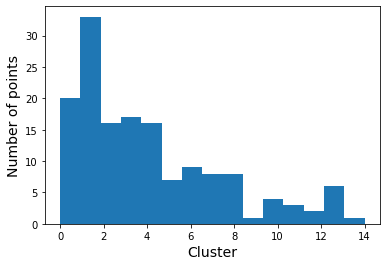

In [86]:
#for semantic_metric in semantic_metrics:
semantic_metric = 'l2_norm'
dim = 10
n_points_per_cluster = 2
n_samples = 1
datapoints, gt_pareto_points, points_df = get_pareto_front(ss.candidates, semantic_metric)
explored_points, est_pareto_points, clusters = cluster_sampling(ss, n_samples, 1, semantic_metric, dim, n_points_per_cluster)

In [87]:
points_df['Cluster'] = clusters
# for each cluster, calculate the count of each cluster, and mean and std of utility and semantic metric
#cluster_stats = points_df.groupby('Cluster').agg({'Utility': ['mean', 'std'], "Semantic": ['mean', 'std']})
cluster_stats = points_df.groupby('Cluster').agg({'Utility': ['mean', 'std','count'], "Semantic": ['mean', 'std']})
# order by semantic mean
cluster_stats = cluster_stats.sort_values(('Semantic', 'mean'))
print(cluster_stats)

          Utility                  Semantic          
             mean       std count      mean       std
Cluster                                              
0        0.581981  0.112141    20  0.114218  0.034485
1        0.603051  0.111925    33  0.177585  0.028239
14       0.999689       NaN     1  0.178372       NaN
11       0.893344  0.136421     3  0.214672  0.001113
10       0.957265  0.010587     4  0.215204  0.000266
3        0.661219  0.114019    17  0.244554  0.015803
12       0.947319  0.016702     2  0.277866  0.001595
13       0.793888  0.171013     6  0.277932  0.000712
4        0.659159  0.109158    16  0.291048  0.014195
2        0.640016  0.152037    16  0.344543  0.016243
7        0.755789  0.170227     8  0.374491  0.002924
6        0.614746  0.182543     9  0.404113  0.018979
5        0.671462  0.172738     7  0.447372  0.011597
8        0.711480  0.192544     8  0.533899  0.007275
9        0.568609       NaN     1  1.000000       NaN


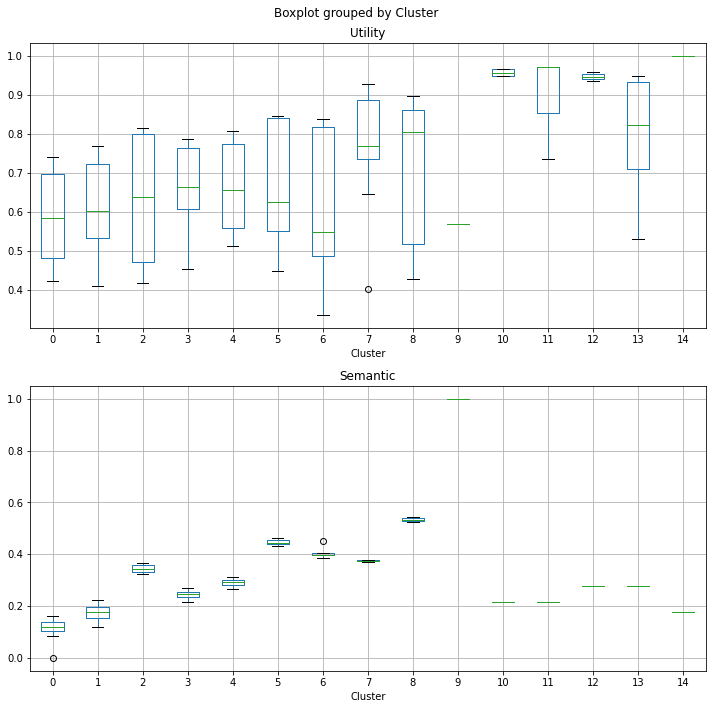

In [88]:
# plot box plots of utility and semantic metric for each cluster
fig, axs = plt.subplots(2,1, figsize=(10,10))
points_df.boxplot(column=['Utility'], by='Cluster', ax=axs[0])
points_df.boxplot(column=['Semantic'], by='Cluster', ax=axs[1])
plt.tight_layout()
# change two subplots to on top of each other
plt.show()

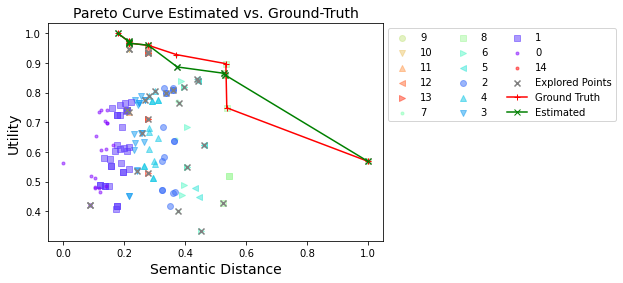

In [89]:
# plot scatter plot of utility and semantic metric for each cluster
import matplotlib.cm as cm
def plot_pareto_points(pareto_points:List, est_pareto_points:List, explored_points:List=None, points_df=None) -> Tuple:
    """
    Plot the estimated and ground truth Pareto fronts.
    Args:
        pareto_points (List): Ground truth Pareto front
        est_pareto_points (List): Estimated Pareto front
    """
    # Sort the points for plotting
    pareto_points = sorted(pareto_points, key=lambda x: x[0])
    est_pareto_points = sorted(est_pareto_points, key=lambda x: x[0])
    # Plot the Pareto front
    pareto_points = np.array(pareto_points)
    est_pareto_points = np.array(est_pareto_points)
    #datapoints = np.array(datapoints)
    # Set size of the plot
    fig, ax = plt.subplots(figsize=(6, 4))
    #f, ax = plt.subplots()
    #ax.scatter(datapoints[0], datapoints[1], c='gray', label='Data Points', alpha=0.3)
    markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
    colors = cm.rainbow(np.linspace(0, 1, len(points_df['Cluster'].unique())))
    for cluster in points_df['Cluster'].unique():
        cluster_points = points_df[points_df['Cluster'] == cluster]
        marker_index = int(cluster % len(markers))
        ax.scatter(cluster_points['Semantic'], cluster_points['Utility'], label=cluster, color=colors[cluster], alpha=0.5, marker=markers[marker_index])

    ax.scatter(explored_points[0], explored_points[1], c='gray', label='Explored Points', marker='x',)
    ax.plot(pareto_points[:, 0], pareto_points[:, 1], '+-', c='red', label='Ground Truth')
    ax.plot(est_pareto_points[:, 0], est_pareto_points[:, 1], 'x-', c='green', label='Estimated')
    ax.legend(bbox_to_anchor=(1, 1),ncol=3)
    ax.set_xlabel('Semantic Distance', fontsize=14)
    ax.set_ylabel('Utility', fontsize=14)
    ax.set_title('Pareto Curve Estimated vs. Ground-Truth', fontsize=14)
    return fig, ax

fig, ax = plot_pareto_points(gt_pareto_points, est_pareto_points, explored_points, points_df)
plt.show()

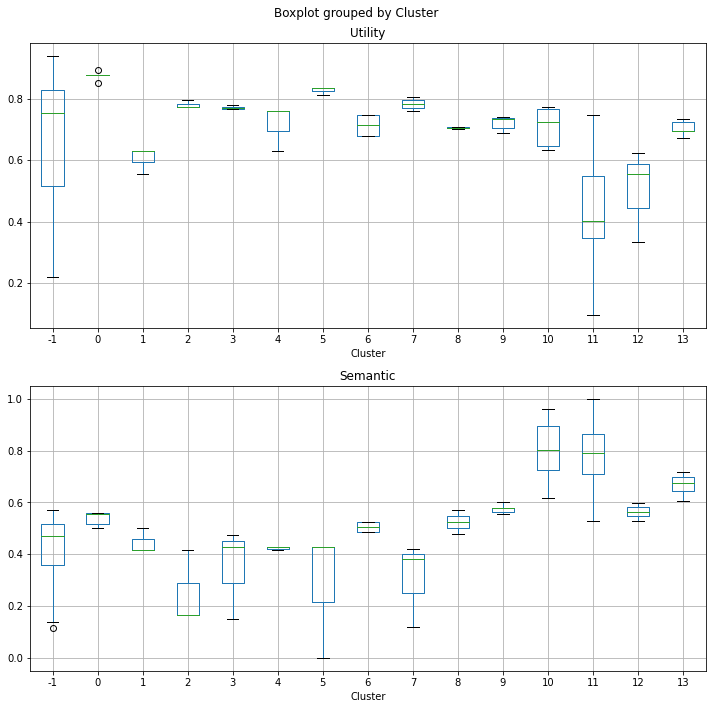

In [54]:
# plot box plots of utility and semantic metric for each cluster
fig, axs = plt.subplots(2,1, figsize=(10,10))
points_df.boxplot(column=['Utility'], by='Cluster', ax=axs[0])
points_df.boxplot(column=['Semantic'], by='Cluster', ax=axs[1])
plt.tight_layout()
# change two subplots to on top of each other
plt.show()

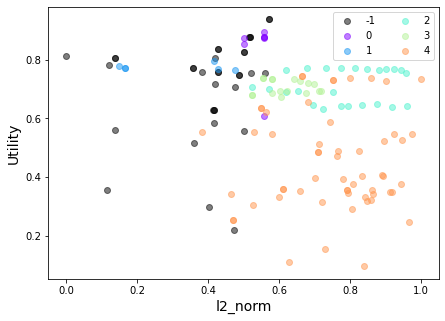

In [63]:
# plot scatter plot of utility and semantic metric for each cluster
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(7,5))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(clusters))))
for cluster in np.unique(clusters):
    cluster_points = points_df[points_df['Cluster'] == cluster]
    if cluster == -1:ax.scatter(cluster_points['Semantic'], cluster_points['Utility'], label=cluster, color='black', alpha=0.5)
    else: ax.scatter(cluster_points['Semantic'], cluster_points['Utility'], label=cluster, color=colors[cluster], alpha=0.5)
ax.legend(bbox_to_anchor=(1, 1),ncol=2)
plt.xlabel(semantic_metric, fontsize=14)
plt.ylabel('Utility', fontsize=14)
plt.show()

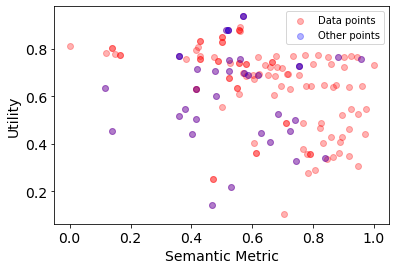

In [57]:
# top 3 biggest clusters
top_n = 1
cluster_sizes = np.unique(clusters, return_counts=True)
top_clusters = cluster_sizes[0][np.argsort(cluster_sizes[1])[-top_n:]]
top_cluster_indices = []
for c in top_clusters:
    top_cluster_indices.extend(np.where(clusters == c)[0])
top_cluster_points = [ss.candidates[i] for i in top_cluster_indices]
top_cluster_points = get_points(top_cluster_points, semantic_metric)

datapoints = np.array(datapoints)
otherpoints = np.array(top_cluster_points)
#print("Percentage of outliers:", len(outliers[0]) / len(datapoints[0]) * 100)
# Set size of the plot
f, ax = plt.subplots(figsize=(6, 4))
ax.scatter(datapoints[0], datapoints[1], c='red', label='Data points', alpha=0.3)
ax.scatter(otherpoints[0], otherpoints[1], c='blue', label='Other points', alpha=0.3)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Semantic Metric', fontsize=14)
ax.set_ylabel('Utility', fontsize=14)
ax.legend()
plt.show()

Percentage of outliers: 13.013698630136986


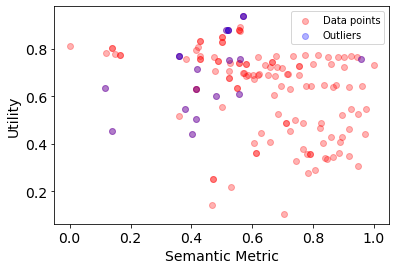

In [43]:
datapoints = np.array(datapoints)
outliers = np.array(outliers)
print("Percentage of outliers:", len(outliers[0]) / len(datapoints[0]) * 100)
# Set size of the plot
f, ax = plt.subplots(figsize=(6, 4))
ax.scatter(datapoints[0], datapoints[1], c='red', label='Data points', alpha=0.3)
ax.scatter(outliers[0], outliers[1], c='blue', label='Outliers', alpha=0.3)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Semantic Metric', fontsize=14)
ax.set_ylabel('Utility', fontsize=14)
ax.legend()
plt.show()

## Load experiment data

In [49]:
use_case = 'imputation'
dataset = 'pima'
dst_folder = os.path.join(ppath, 'exp', f"{dataset}_2024_09_25_run1", use_case)
attributes = ['Age', 'Glucose', 'BMI']
data = []
for attribute in attributes:
    quality = pd.read_csv(os.path.join(dst_folder, f'{attribute}_quality.csv'))
    runtime = pd.read_csv(os.path.join(dst_folder, f'{attribute}_runtime.csv'))

    # Join quality and runtime dataframes on ['use_case', 'dataset', 'attr', 'method', 'semantic_metric']
    df = pd.merge(quality, runtime, on=['use_case', 'dataset', 'attr', 'method', 'semantic_metric'])
    data.append(df)
data = pd.concat(data)

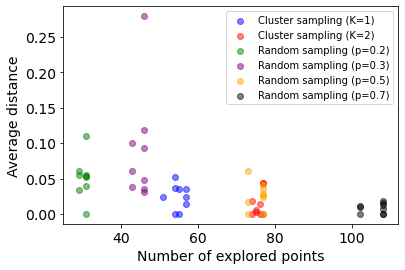

In [51]:
f, ax = plt.subplots(figsize=(6, 4))
methods = data['method'].unique()
method_names = ['Cluster sampling (K=1)', 'Cluster sampling (K=2)', 'Random sampling (p=0.2)', 'Random sampling (p=0.3)', 'Random sampling (p=0.5)', 'Random sampling (p=0.7)']
# 5 colors for 5 methods
colors = ['blue', 'red', 'green', 'purple', 'orange', 'black']
for i, method in enumerate(methods):
    ax.scatter(data[data['method'] == method]['num_explored_points'], data[data['method'] == method]['avg_dist'], label=method_names[i], c = colors[i], alpha=0.5)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Number of explored points', fontsize=14)
ax.set_ylabel('Average distance', fontsize=14)
ax.legend()
plt.show()

In [10]:
# Make a dataframe, where each coloumn is a method and rows are means, stds of avg_dist and num_explored_points
results = pd.DataFrame()
for method in methods:
    results[method] = [data[data['method'] == method]['avg_dist'].mean(), data[data['method'] == method]['avg_dist'].std(), int(data[data['method'] == method]['num_explored_points'].mean())]
    # Round to 2 decimal places
    results[method] = results[method].apply(lambda x: round(x, 3))
results.index = ['mean_avg_dist', 'std_avg_dist', 'mean_num_explored_points']
results

,cluster_sampling_1_1,cluster_sampling_2_1,random_sampling_0.2,random_sampling_0.3,random_sampling_0.5,random_sampling_0.7
mean_avg_dist,0.025,0.014,0.051,0.089,0.026,0.008
std_avg_dist,0.018,0.018,0.029,0.078,0.019,0.007
mean_num_explored_points,54.000,75.000,30.000,45.000,75.000,106.000


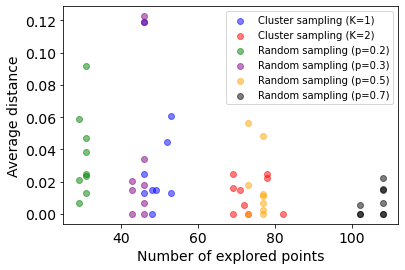

In [52]:
use_case = 'modelling'
dataset = 'pima'
dst_folder = os.path.join(ppath, 'exp', f"{dataset}_2024_09_29_run1", use_case)
attributes = ['Age', 'Glucose', 'BMI']
data = []
for attribute in attributes:
    quality = pd.read_csv(os.path.join(dst_folder, f'{attribute}_quality.csv'))
    runtime = pd.read_csv(os.path.join(dst_folder, f'{attribute}_runtime.csv'))

    # Join quality and runtime dataframes on ['use_case', 'dataset', 'attr', 'method', 'semantic_metric']
    df = pd.merge(quality, runtime, on=['use_case', 'dataset', 'attr', 'method', 'semantic_metric'])
    data.append(df)
data = pd.concat(data)

f, ax = plt.subplots(figsize=(6, 4))
methods = data['method'].unique()
method_names = ['Cluster sampling (K=1)', 'Cluster sampling (K=2)', 'Random sampling (p=0.2)', 'Random sampling (p=0.3)', 'Random sampling (p=0.5)', 'Random sampling (p=0.7)']
# 5 colors for 5 methods
colors = ['blue', 'red', 'green', 'purple', 'orange', 'black']
for i, method in enumerate(methods):
    ax.scatter(data[data['method'] == method]['num_explored_points'], data[data['method'] == method]['avg_dist'], label=method_names[i], c = colors[i], alpha=0.5)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Number of explored points', fontsize=14)
ax.set_ylabel('Average distance', fontsize=14)
ax.legend()
plt.show()

In [14]:
# Make a dataframe, where each coloumn is a method and rows are means, stds of avg_dist and num_explored_points
results = pd.DataFrame()
for method in methods:
    results[method] = [data[data['method'] == method]['avg_dist'].mean(), data[data['method'] == method]['avg_dist'].std(), int(data[data['method'] == method]['num_explored_points'].mean())]
    # Round to 2 decimal places
    results[method] = results[method].apply(lambda x: round(x, 3))
results.index = ['mean_avg_dist', 'std_avg_dist', 'mean_num_explored_points']
results

,cluster_sampling_1_1,cluster_sampling_2_1,random_sampling_0.2,random_sampling_0.3,random_sampling_0.5,random_sampling_0.7
mean_avg_dist,0.034,0.012,0.036,0.037,0.017,0.007
std_avg_dist,0.037,0.011,0.027,0.049,0.021,0.008
mean_num_explored_points,49.000,73.000,30.000,45.000,75.000,106.000


In [181]:
raw_data = pd.read_csv(os.path.join(ppath, 'data', 'statlog+landsat+satellite', 'sat.trn'), header=None, delim_whitespace=True)
#raw_data.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
raw_data.columns = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'target']
raw_data

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p27,p28,p29,p30,p31,p32,p33,p34,p35,target
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,56,64,108,96,64,71,108,96,68,75,...,92,66,83,108,96,66,87,104,89,5
4431,64,71,108,96,68,75,108,96,71,87,...,96,66,87,104,89,63,87,104,89,5
4432,68,75,108,96,71,87,108,88,71,91,...,89,63,87,104,89,70,100,104,85,4
4433,71,87,108,88,71,91,100,81,76,95,...,89,70,100,104,85,70,91,104,85,4


## Individual setup (per attribute-semantic)

In [95]:
use_case = 'imputation'
dataset = 'satimage'
dst_folder = os.path.join(ppath, 'exp', f"{dataset}.2024_10_22.linkage_distributions.test1", use_case)
exp_config = json.load(open(os.path.join(ppath, 'code', 'configs', f'{dataset}.json')))
attributes = list(exp_config['attributes'].keys())
dfs = []
for attribute in attributes[:5]:
    quality = pd.read_csv(os.path.join(dst_folder, f'{attribute}_quality.csv'))
    runtime = pd.read_csv(os.path.join(dst_folder, f'{attribute}_runtime.csv'))

    # Join quality and runtime dataframes on ['use_case', 'dataset', 'attr', 'method', 'semantic_metric']
    df = pd.merge(quality, runtime, on=['use_case', 'dataset', 'attr', 'method', 'semantic_metric', 'round'])
    dfs.append(df)
#data = pd.concat(data)

In [96]:
df['method'].unique()

array(['cluster_sampling_random', 'cluster_sampling_proportional',
       'cluster_sampling_reverse', 'random_sampling_0.2',
       'random_sampling_0.4', 'random_sampling_0.5',
       'random_sampling_0.8'], dtype=object)

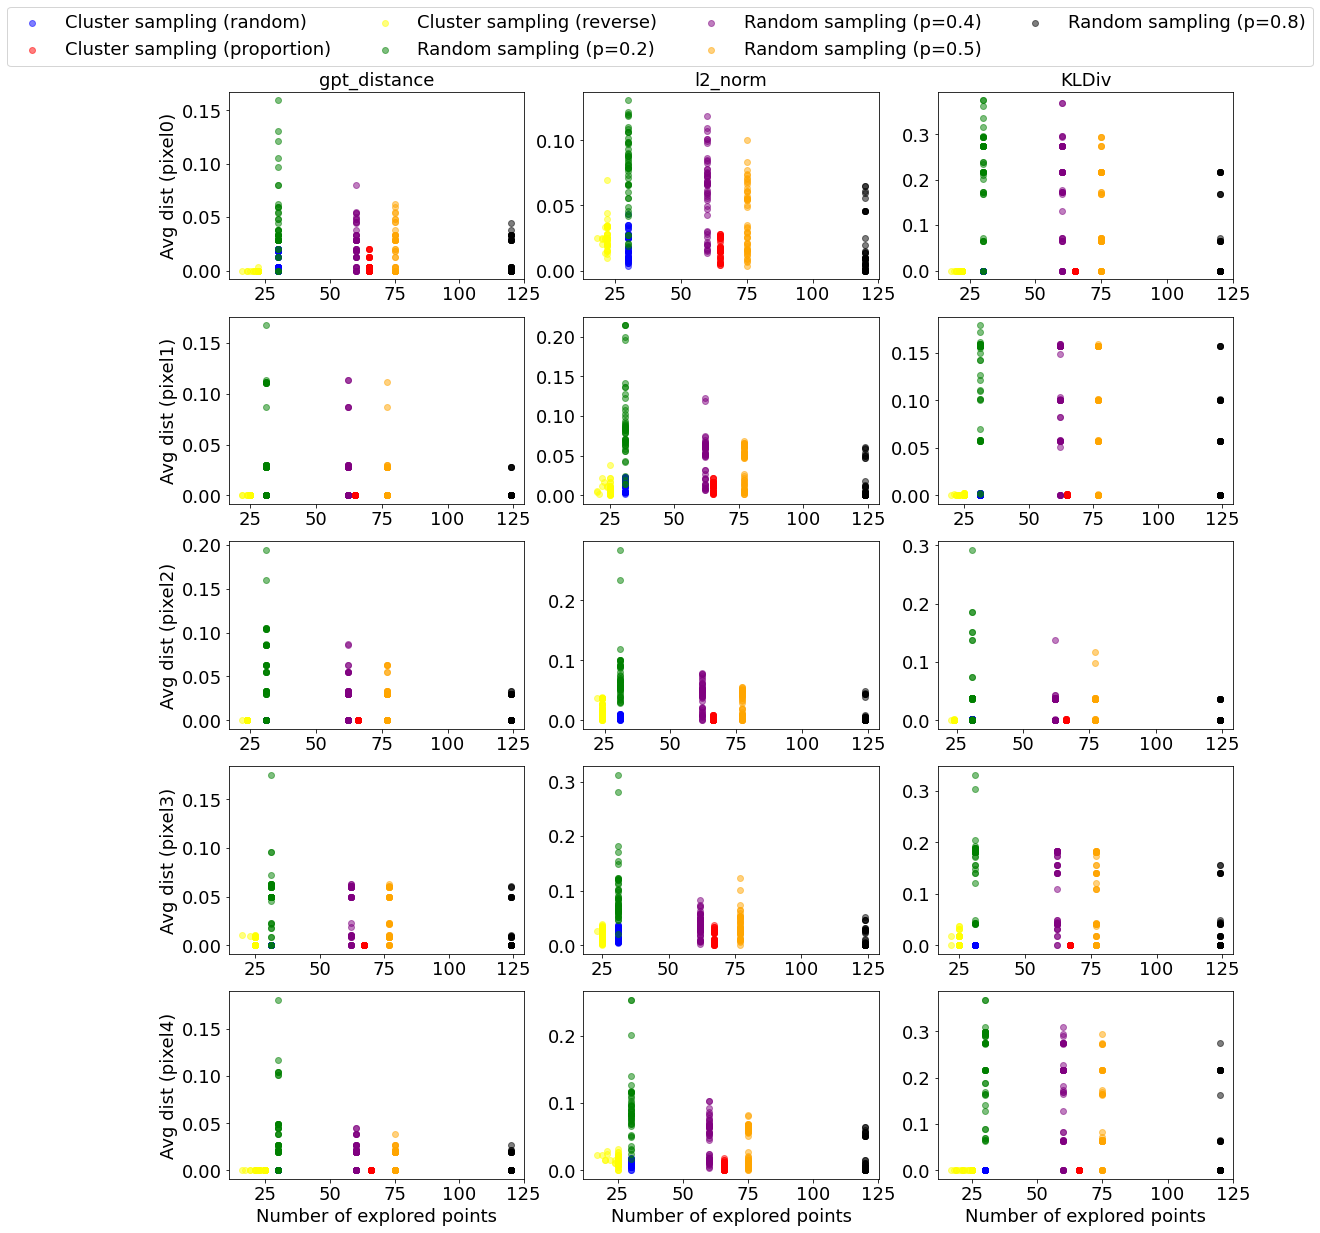

In [98]:
row = len(dfs)
fig, axs = plt.subplots(row, 3, figsize=(18, row*4))
method_names = ['Cluster sampling (random)', 'Cluster sampling (proportion)', 'Cluster sampling (reverse)', 'Random sampling (p=0.2)', 'Random sampling (p=0.4)', 'Random sampling (p=0.5)', 'Random sampling (p=0.8)']
# 5 colors for 5 methods
colors = ['blue', 'red', 'yellow', 'green', 'purple', 'orange', 'black']
#colors = cm.rainbow(np.linspace(0, 1, len(method_names)))
semantic_metrics = ['gpt_distance', 'l2_norm', 'KLDiv']
font_size = 18

for k, df in enumerate(dfs):
    for i, semantic_metric in enumerate(semantic_metrics):
        data = df[df['semantic_metric'] == semantic_metric]
        #df = df[df['method'].isin(methods)]
        methods = data['method'].unique()
        ax = axs[k][i]
        for j, method in enumerate(methods):
            ax.scatter(data[data['method'] == method]['num_explored_points'], data[data['method'] == method]['avg_dist'], label=method_names[j], c = colors[j], alpha=0.5)
        ax.xaxis.set_tick_params(labelsize=font_size)
        ax.yaxis.set_tick_params(labelsize=font_size)
        if k == row-1: ax.set_xlabel('Number of explored points', fontsize=font_size)
        if k == 0: ax.set_title(semantic_metric, fontsize=font_size)
        if i == 0: ax.set_ylabel(f'Avg dist ({attributes[k]})', fontsize=font_size)
        #if i == 2: ax.legend()
        if k==0 and i==0: ax.legend(ncol=4, fontsize=font_size, bbox_to_anchor=(3.7,1.5))
fig.tight_layout()
plt.show()

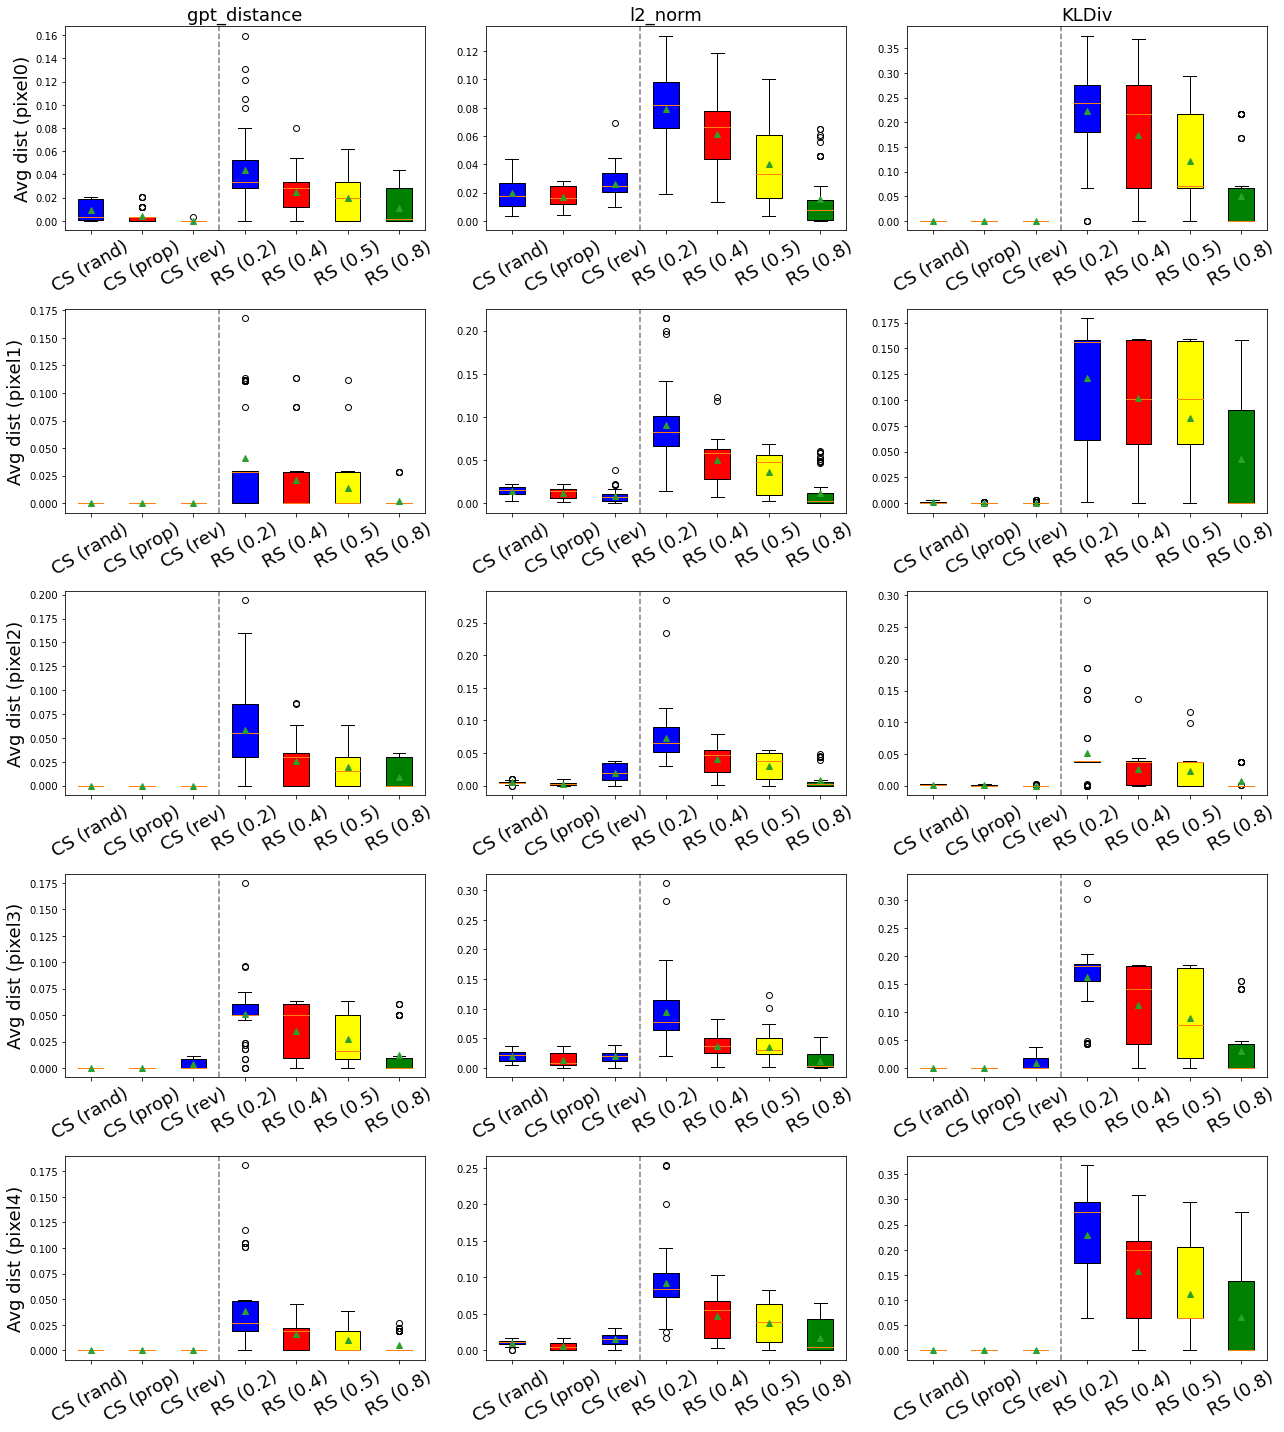

In [99]:
# box plot of avg_dist for each method
row = len(dfs)
fig, axs = plt.subplots(row, 3, figsize=(18, row*4))
method_names = ['CS (rand)', 'CS (prop)', 'CS (rev)', 'RS (0.2)', 'RS (0.4)', 'RS (0.5)', 'RS (0.8)']
colors = ['blue', 'red', 'blue', 'blue', 'red', 'yellow', 'green']
font_size = 18
methods = ['cluster_sampling_random', 'cluster_sampling_proportional',
       'cluster_sampling_reverse', 'random_sampling_0.2']
for k, df in enumerate(dfs):
    for i, semantic_metric in enumerate(semantic_metrics):
        data = df[df['semantic_metric'] == semantic_metric]
        ax = axs[k][i]
        bp = ax.boxplot([data[data['method'] == method]['avg_dist'] for method in df['method'].unique()], labels=method_names, showmeans=True, patch_artist=True)
        ax.set_xticklabels(method_names, rotation=30)
        ax.xaxis.set_tick_params(labelsize=font_size)
        if k == 0: ax.set_title(semantic_metric, fontsize=font_size)
        if i == 0: ax.set_ylabel(f'Avg dist ({attributes[k]})', fontsize=font_size)
        ax.axvline(x=3.5, color='gray', linestyle='--')
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
fig.tight_layout()
plt.show()

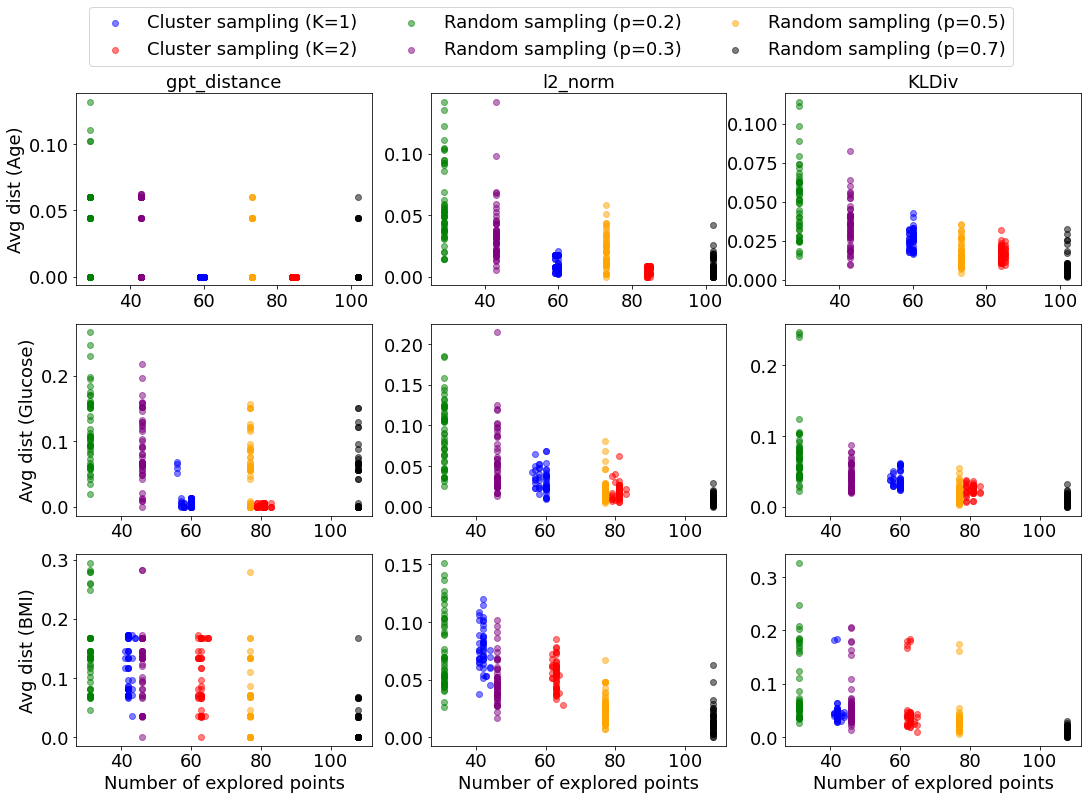

In [35]:
use_case = 'imputation'
dataset = 'pima'
dst_folder = os.path.join(ppath, 'exp', f"{dataset}_2024_10_02_run2", use_case)
attributes = ['Age', 'Glucose', 'BMI']
dfs = []
for attribute in attributes:
    quality = pd.read_csv(os.path.join(dst_folder, f'{attribute}_quality.csv'))
    runtime = pd.read_csv(os.path.join(dst_folder, f'{attribute}_runtime.csv'))

    # Join quality and runtime dataframes on ['use_case', 'dataset', 'attr', 'method', 'semantic_metric']
    df = pd.merge(quality, runtime, on=['use_case', 'dataset', 'attr', 'method', 'semantic_metric', 'round'])
    dfs.append(df)
#data = pd.concat(data)

#f, ax = plt.subplots(figsize=(6, 4))
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
methods = data['method'].unique()
method_names = ['Cluster sampling (K=1)', 'Cluster sampling (K=2)', 'Random sampling (p=0.2)', 'Random sampling (p=0.3)', 'Random sampling (p=0.5)', 'Random sampling (p=0.7)']
# 5 colors for 5 methods
colors = ['blue', 'red', 'green', 'purple', 'orange', 'black']
semantic_metrics = ['gpt_distance', 'l2_norm', 'KLDiv']
font_size = 18

for k, df in enumerate(dfs):
    for i, semantic_metric in enumerate(semantic_metrics):
        data = df[df['semantic_metric'] == semantic_metric]
        ax = axs[k][i]
        for j, method in enumerate(methods):
            ax.scatter(data[data['method'] == method]['num_explored_points'], data[data['method'] == method]['avg_dist'], label=method_names[j], c = colors[j], alpha=0.5)
        ax.xaxis.set_tick_params(labelsize=font_size)
        ax.yaxis.set_tick_params(labelsize=font_size)
        if k == 2: ax.set_xlabel('Number of explored points', fontsize=font_size)
        if k == 0: ax.set_title(semantic_metric, fontsize=font_size)
        if i == 0: ax.set_ylabel(f'Avg dist ({attributes[k]})', fontsize=font_size)
        #if i == 2: ax.legend()
        if k==0 and i==0: ax.legend(ncol=3, fontsize=font_size, bbox_to_anchor=(3.2,1.5))
fig.tight_layout()
plt.show()

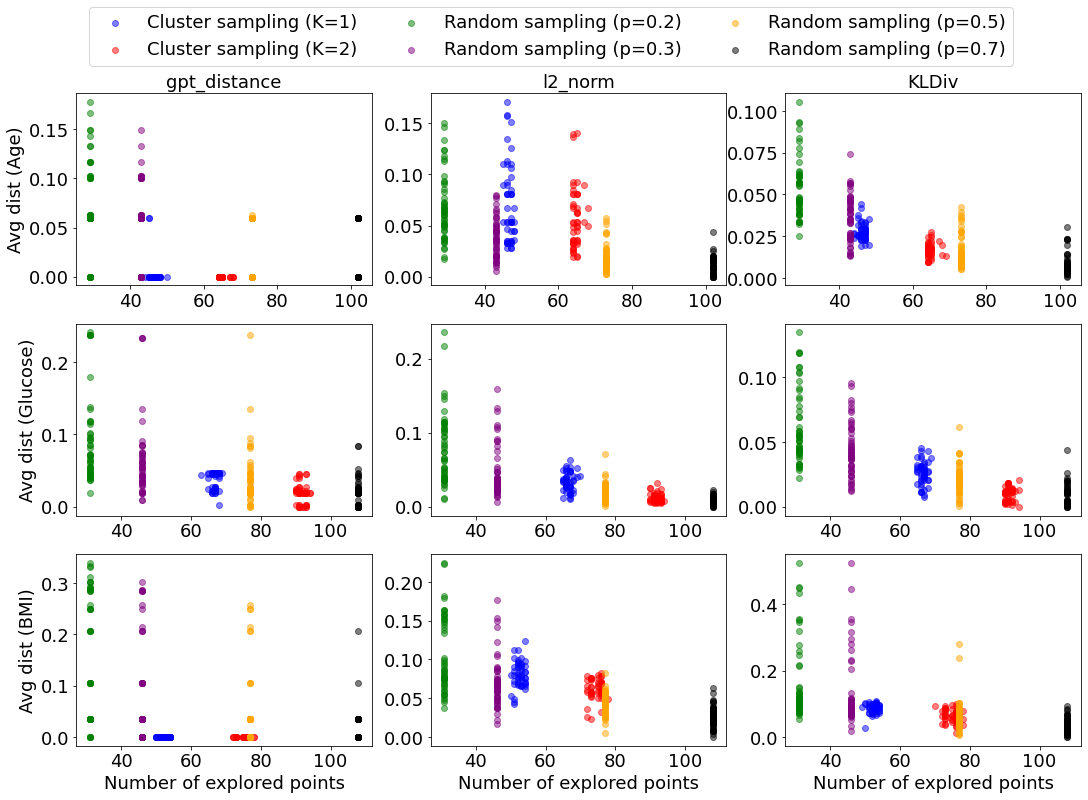

In [34]:
use_case = 'imputation'
dataset = 'pima'
dst_folder = os.path.join(ppath, 'exp', f"{dataset}_2024_10_02_run3", use_case)
attributes = ['Age', 'Glucose', 'BMI']
dfs = []
for attribute in attributes:
    quality = pd.read_csv(os.path.join(dst_folder, f'{attribute}_quality.csv'))
    runtime = pd.read_csv(os.path.join(dst_folder, f'{attribute}_runtime.csv'))

    # Join quality and runtime dataframes on ['use_case', 'dataset', 'attr', 'method', 'semantic_metric']
    df = pd.merge(quality, runtime, on=['use_case', 'dataset', 'attr', 'method', 'semantic_metric', 'round'])
    dfs.append(df)
#data = pd.concat(data)

#f, ax = plt.subplots(figsize=(6, 4))
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
methods = data['method'].unique()
method_names = ['Cluster sampling (K=1)', 'Cluster sampling (K=2)', 'Random sampling (p=0.2)', 'Random sampling (p=0.3)', 'Random sampling (p=0.5)', 'Random sampling (p=0.7)']
# 5 colors for 5 methods
colors = ['blue', 'red', 'green', 'purple', 'orange', 'black']
semantic_metrics = ['gpt_distance', 'l2_norm', 'KLDiv']
font_size = 18

for k, df in enumerate(dfs):
    for i, semantic_metric in enumerate(semantic_metrics):
        data = df[df['semantic_metric'] == semantic_metric]
        ax = axs[k][i]
        for j, method in enumerate(methods):
            ax.scatter(data[data['method'] == method]['num_explored_points'], data[data['method'] == method]['avg_dist'], label=method_names[j], c = colors[j], alpha=0.5)
        ax.xaxis.set_tick_params(labelsize=font_size)
        ax.yaxis.set_tick_params(labelsize=font_size)
        if k == 2: ax.set_xlabel('Number of explored points', fontsize=font_size)
        if k == 0: ax.set_title(semantic_metric, fontsize=font_size)
        if i == 0: ax.set_ylabel(f'Avg dist ({attributes[k]})', fontsize=font_size)
        #if i == 2: ax.legend()
        if k==0 and i==0: ax.legend(ncol=3, fontsize=font_size, bbox_to_anchor=(3.2,1.5))
fig.tight_layout()
plt.show()